# Replication Project: A quantitative theory of the gender gap in wages (Erosa, Fuster & Restuccia 2016)
Solving the dynamic model of the paper is a high dimensional problem that requires a lot of computational power. However, lot of computations can be made in parallel instead of sequentially. Consequently, we can shorten the running time significantly by relying on parallel computing packages. As recommended by Fernández-Villaverde & Zarruk (2018) we use the packages "Distributed" and "SharedArrays".
In a first step we load the packages and define the number of workers used in parallel computing. Note that we load the "Interpolations" package accompanied by the *@everywhere* command to make it accessible to all processing units used in the parallel computation.

For the rest of the code *@everywhere* is used to define objects that are unalterable and all workers of parallel computation need to access. Alterable variables and matrices are created via the *SharedArray* command.

In [1]:
using Plots, Distributed, SharedArrays, Distributions, QuantEcon, Interpolations, JLD#, Interpolations
addprocs(4) #Number of workers used in parallel computing
@everywhere using Interpolations

To increase speed additionally, we exploit properties of the Julia language. We do so by running computations within functions and using unalterable variables as parameter inputs for the model. For the latter we define a new type structure that summarizes all input parameters. We also include a function that helps us to create such a parameter structure with our desired values. The default input values are for the case of non-college females.

In [2]:
@everywhere struct Parameters
    α_1::Float64
    α_2::Float64
    γ_h::Float64
    intercept::Float64
    age1::Float64
    age2::Float64
    age3::Float64
    child::Float64
    interact::Float64
    gp_ν_s::Int64
    grid_ν_s::Vector{Float64}
    gp_ν_c::Int64
    grid_ν_c::Vector{Float64}
    markov::Matrix{Float64}
    aux_ages::Array{Int64}
    aux_ν::Array{Float64}
    gp_h::Int64
    grid_h::Vector{Float64}
    gp_n::Int64
    grid_n::Vector{Float64}
    starting_age::Int64
    J::Int64
    β::Float64
    θ::Array{Float64,2}
    Δ::Float64
    μ_h::Float64
    σ_h::Float64
    μ_v_c::Float64
    hours_factor::Float64
    ρ::Float64
    σ::Float64

    function Parameters(α_1 = 0.351;
                        α_2 = 0.379,
                        γ_h = 1.0,
                        intercept = 0.196,
                        age1 = 3.32,
                        age2 = -0.086,
                        age3 = 0.0007,
                        child = -6.81,
                        interact = 0.133,
                        markov,
                        grid_ν_s,
                        gp_ν_s = 7,
                        μ_ν_c = 0.7,
                        gp_ν_c = 7,
                        aux_ages = [17, 20, 25, 30, 40, 50, 55, 60, 65],
                        aux_ν = [8.0, 1.12, 0.42, 0.29, 0.25, 0.24, 0.25, 0.34, 1.6],
                        min_h = 0.0001,
                        max_h = 450,
                        gp_h = 201,
                        gp_n = 5,
                        starting_age = 17,
                        β = 0.99,
                        Δ = 3.0,
                        μ_h = 0.728,
                        σ_h = 0.233,
                        μ_v_c = 0.7,
                        ρ = 0.76,
                        σ = 0.79,
                        black = false)
        grid_h = collect(range(min_h, stop = max_h, length=gp_h))
        grid_n = collect(range(0, stop = gp_n-1, length = gp_n))
        J = 4*(65-starting_age)
        percentile_ν_c = 0.9 # set percentile
        max_ν_c = -log(1-percentile_ν_c)/μ_ν_c
        grid_ν_c = collect(range(0, stop = max_ν_c, length=gp_ν_c))
        if starting_age==17 ##Non-college
            if black==false
                #baseline case
                aux1=[fill(0.0269,5*4); fill(0.0265,5*4); fill(0.0265,5*4); fill(0.0090,8*4); fill(0.0,25*4)]
                aux2=[1.0 1.44 0.76 fill(0.76,gp_n-3)']
                θ = aux1*aux2
                hours_factor = 44.2/40.5 #from table 1
            else
                #race experiment
                aux1=[fill(0.0415,5*4); fill(0.0260,5*4); fill(0.0237,5*4); fill(0.0044,8*4); fill(0.0,25*4)]
                aux2=[1.0 1.62 1.167 fill(1.06,gp_n-3)']
                θ = aux1*aux2
                hours_factor = 44.2/40.5 #from table 1
            end
        elseif starting_age==20 ## College
            aux1=[fill(0.0082,5*4); fill(0.0210,5*4); fill(0.0259,5*4); fill(0.0086,5*4); fill(0.0,25*4)]
            aux2=[1.0 2.66 0.76 fill(1.27,gp_n-3)']
            θ = aux1*aux2
            hours_factor = 46.2/42.7 #from table 1
        end
        new(α_1, α_2, γ_h, intercept, age1, age2, age3, child, interact, gp_ν_s, grid_ν_s, gp_ν_c, grid_ν_c, markov, aux_ages, aux_ν, gp_h, grid_h, gp_n, grid_n, starting_age, J, β, θ, Δ, μ_h, σ_h, μ_v_c, hours_factor, ρ, σ)
    end
end

In the next field we define a few functions that are needed within the functions that will solve for the optimal policies later on. The former include primarily three value functions: $W^j(h,n,\nu)$, $H^j(h,n,\nu)$, and $V^j(h,n,\nu)$, which denote the value of working, staying at home, and the value of optimally deciding between these two options, respectively. Their functional form is defined on pages 174 and 175 in the paper. These values rely, among others, on the number of working hours $l(j,n)$, the value of optimal human capital accumulation $HCA(\cdot)$, and the cost of exerting effort $c(j,h)$. Consequently, these three functions are also defined.

Optimal human capital accumulation has a closed form solution. The function returns $HCA(\cdot)$ the value of optimal effort and optimal effort itself obtained from this closed form solution. The derivation is as follows:

\begin{align}
    \max_e c(j,h)log(1-e)+e\hat{V}^j(h(1+\Delta),n,\nu)&+(1-e)\hat{V}^j(h,n,\nu) \\
    -\frac{c(j,h)}{(1-e)} +\hat{V}^j(h(1+\Delta),n,\nu) - \hat{V}^j(h,n,\nu) &= 0 \\
    (1-e)(\hat{V}^j(h(1+\Delta),n,\nu) - \hat{V}^j(h,n,\nu)) &= c(j,h) \\
    1-e &= \frac{c(j,h)}{\hat{V}^j(h(1+\Delta),n,\nu) - \hat{V}^j(h,n,\nu)} \\
    e &= 1-\frac{c(j,h)}{\hat{V}^j(h(1+\Delta),n,\nu) - \hat{V}^j(h,n,\nu)}
\end{align}

In [5]:
@everywhere function c(j,h,P::Parameters) #cost function for exerting effort
    age = P.starting_age+(j-1)/4
    return (P.α_1+age^(P.α_2))*h^(P.γ_h)
end
@everywhere function HCA(c,V_hat,V_hat_delta) #Optimal human capital accumulation (HCA)
    e = max(1-c/(V_hat_delta-V_hat),0)        #closed form solution of optimal effort
    if e>1
        error("outside of definition")
    end
    return (c*log(1-e)+e*V_hat_delta+(1-e)*V_hat, e)
end

@everywhere function l(j,n,P::Parameters) #working hours depending on age "j" and number of children "n"
    if j < 40
        P.intercept+P.age1*j+P.age2*j^2+P.age3*j^3+P.child*n+P.interact*n*j
        else#working hours reduction due to children becomes obsolete after age 40
        P.intercept+P.age1*j+P.age2*j^2+P.age3*j^3
    end
end

@everywhere function W(j,h,n,ν,VV_hat,VV_hat_delta,ll,P::Parameters) #Value of working
    cc = c(j,h,P)
    (opt_HCA,e) = HCA(cc,VV_hat,VV_hat_delta)
    uu = h*ν
    aux_val = h*ll + (1-ll)*uu + P.γ_h*log(1+n) + opt_HCA
    return (aux_val, e)
end

@everywhere function H(j,h,n,ν,γ_n,VV_hat) #Value of staying at home
    uu = h*ν
    return uu + γ_n*log(1+n)+VV_hat
end

@everywhere function V(j,h,n,P::Parameters) #Value of optimal labor decision
    max(H(j,h,n,P::Parameters),V(j,h,n,P::Parameters))
end

Subsequently, we define the function that solves the policy functions for men. In a first bloc all the needed matrices are preallocated. We have three value functions for working, staying at home, and the optimal decision between the two. Furthermore, we have two policy functions: optimal decision of going to work (or not) and optimal exerted effort. Additionally, we have some auxiliary variables that need preallocation to perform parallel computing.

The state of a man is fully defined by the three variables: the level of human capital, the period withing the life-cycle and the stochastic value of staying at home $\nu_s$. The three variables then determine the size of the three dimensions that the policy and value functions have. Note that the paper only denotes two state variables for men: $\nu$ and the stock of human capital. However, for men $\nu$ has two dimensions as it equals $\nu=\nu_j \nu_s$. The notation of the paper therefore implicitely also includes the same three dimensions.

We use backwards induction to solve for all the combinations of human capital level and $\nu_s$ gridpoints. We start with the last period $J$, where the value is determined myopically. For all other periods, we use the value of the next period to include the dynamic component. Due to the stochastic components, the value of entering the next period is an expected value. The stochasticity has two components: First, whether the effort of human capital accumulation is successful. This only applies in the case of working. Second, the stochastic value of staying at home $\nu_s$ that follows an AR(1) process. We approximate the AR(1) process with the Tauchen method. This means that we discretize the continuous AR(1) process to a markov matrix with according gridpoints.

In [20]:
function male_policy(P::Parameters)
    #Preallocation
    #Value functions
    W_value = SharedArray{Float64}(P.gp_h, P.J, P.gp_ν_s) #Working
    H_value = SharedArray{Float64}(P.gp_h, P.J, P.gp_ν_s) #Staying at home
    V_value = SharedArray{Float64}(P.gp_h, P.J, P.gp_ν_s) #Optimal labor decision
    #policy functions
    labor_policy = SharedArray{Float64}(P.gp_h, P.J, P.gp_ν_s) #labor decision
    effort_policy = SharedArray{Float64}(P.gp_h, P.J, P.gp_ν_s) # effort decision
    #initialisation of remaining variables
    age = SharedArray{Float64}(1)
    ll = SharedArray{Float64}(1)
    itp_h = SharedArray{Float64}(P.gp_h,P.gp_ν_s)
    etp_h = SharedArray{Float64}(P.gp_h,P.gp_ν_s)
    knots = (P.aux_ages,)
    int_ν_j = interpolate(knots, P.aux_ν, Gridded(Linear()))
    
    #Solving
    #Last period
    age = P.starting_age+(P.J-1)/4
    ll = P.hours_factor*l(age,0,P) #scale working hours up by exogenous factor
    for (ind_h,h) in enumerate(P.grid_h)
        for (ind_ν, ν_s) in enumerate(P.grid_ν_s)
            ν = int_ν_j[age]*ν_s
            (W_value[ind_h,P.J,ind_ν], effort_policy[ind_h, P.J,ind_ν]) = W(P.J,h,0,ν,10^(-8),10^(-6),ll,P)
            H_value[ind_h,P.J,ind_ν]                                  = H(P.J,h,0,ν,P.γ_h,10^(-8))
            V_value[ind_h,P.J,ind_ν]                                  = max.(W_value[ind_h,P.J,ind_ν],H_value[ind_h,P.J,ind_ν])
            labor_policy[ind_h,P.J,ind_ν]                             = 1*(W_value[ind_h,P.J,ind_ν]>H_value[ind_h,P.J,ind_ν])
        end
    end
    #Backwards induction
    for j in P.J-1:-1:1
        #allocation of auxiliary variables and interpolations that are constant across states
        age = P.starting_age+(j-1)/4
        ll = P.hours_factor*l(age,0,P) #scale working hours up by exogenous factor
        #println(age)
        itp_h = interpolate((P.grid_h,P.grid_ν_s),V_value[:,j+1,:],Gridded(Linear()))
        etp_h = extrapolate(itp_h, Line())
        #solving for all combinations of human capital and ν_s gridpoints
        @sync @distributed for ind in 1:(P.gp_h*P.gp_ν_s)
            #preparing all inputs needed for later calculations
            ind_ν = convert(Int, ceil(ind/P.gp_h))
            ind_h = convert(Int, floor(mod(ind-0.05, P.gp_h))+1)
            h = P.grid_h[ind_h]       #current human capital
            h_delta = h*(1+(P.Δ/100)) #future human capital if accumulation is successful
            ν_s = P.grid_ν_s[ind_ν]   #stochastic component of staying at home
            contval = 0       #initialisation of expected value of next period if HK acc. is NOT successful
            contval_delta = 0 #initialisation of expected value of next period if HK acc. IS successful
            for (ind_ν_2, ν_s_2) in enumerate(P.grid_ν_s)
                contval       = contval      + P.markov[ind_ν,ind_ν_2]*etp_h[h,ν_s_2]
                contval_delta = contval_delta+ P.markov[ind_ν,ind_ν_2]*etp_h[h_delta,ν_s_2]
            end
            ν = int_ν_j[age]*ν_s     #value of staying at home: deterministic component times stochastic component
            #calculating the values and optimal policies
            (W_value[ind_h,j,ind_ν], effort_policy[ind_h, j,ind_ν]) = W(j, h, 0, ν, P.β*contval, P.β*contval_delta, ll, P)
            H_value[ind_h,j,ind_ν] = H(j,h,0,ν,P.γ_h, P.β*contval)
            V_value[ind_h,j,ind_ν] = max.(W_value[ind_h,j,ind_ν],H_value[ind_h,j,ind_ν])
            labor_policy[ind_h,j,ind_ν] = 1*(W_value[ind_h,j,ind_ν]>H_value[ind_h,j,ind_ν])
        end
    end
    return (W_value, H_value, V_value, labor_policy, effort_policy)
end

male_policy (generic function with 1 method)

The female case is an extension of the male case. The model assumes that females differ from males in the regard of their possibility of having children. Consequently, a choice variable is added to the problem, namely the decision to have an additional child (-> child_policy). This means that we include a third policy function for this decision and a fourth value, that denotes the expected value of entering a period and behaving optimally with regard to all choice variables, including the fertility decision. We denote this as B_value.

The addition of fertility decisions opens up two more dimensions in the state of a woman compared to a man. The (stochastic) value of enjoying a newborn child at home $\nu_c$ and the number of children $n$. For the former keep in mind that $\nu$ is defined of being $\nu=\nu_j(\nu_s+\nu_c)$. However, $\nu_c$ can only be enjoyed if a woman has a newborn child. Consequently, we have $\nu=\nu_j(\nu_s+\nu_c)$ if a woman has a newborn and otherwise we have $\nu=\nu_j\nu_s$, as in the male case.

The state of women is then fully defined in five dimensions (the first three are identical to the male case):
* human capital $h$
* age/period $j$
* the stochastic value of staying at home $\nu_s$
* the stochastic value of staying at home with a newborn child $\nu_c$
* the number of children $n$

In [7]:
function female_policy(P::Parameters)
    #Value functions
    W_value = SharedArray{Float64}(P.gp_h, P.J, P.gp_ν_s, P.gp_ν_c, P.gp_n) #Working
    H_value = SharedArray{Float64}(P.gp_h, P.J, P.gp_ν_s, P.gp_ν_c, P.gp_n) #Staying at home
    V_value = SharedArray{Float64}(P.gp_h, P.J, P.gp_ν_s, P.gp_ν_c, P.gp_n) #Optimal labor decision
    B_value = SharedArray{Float64}(P.gp_h, P.J, P.gp_ν_s, P.gp_ν_c, P.gp_n) #Continuation value
    #Policy functions
    labor_policy = SharedArray{Float64}(P.gp_h, P.J, P.gp_ν_s, P.gp_ν_c, P.gp_n) #labor decision
    effort_policy = SharedArray{Float64}(P.gp_h, P.J, P.gp_ν_s, P.gp_ν_c, P.gp_n) #effort decision
    child_policy = SharedArray{Float64}(P.gp_h, P.J, P.gp_ν_s, P.gp_ν_c, P.gp_n) #fertility decision
    #initialisation of remaining variables
    age = SharedArray{Float64}(1)
    ll = SharedArray{Float64}(1)
    itp_h = SharedArray{Float64}(P.gp_h,P.gp_ν_s, P.gp_ν_c)
    etp_h = SharedArray{Float64}(P.gp_h,P.gp_ν_s, P.gp_ν_c)
    knots = (P.aux_ages,)
    int_ν_j = interpolate(knots, P.aux_ν, Gridded(Linear()))

    #Last period
    age = P.starting_age+(P.J-1)/4
    for (ind_n,n) in enumerate(P.grid_n)
        ll = l(age,n,P)
        for (ind_h,h) in enumerate(P.grid_h)
            for (ind_ν, ν_s) in enumerate(P.grid_ν_s)
                ν = int_ν_j[age]*ν_s
                (WW, ee)                                              = W(P.J,h,n,ν,10^(-8),10^(-6),ll,P)
                HH                                                    = H(P.J,h,n,ν,P.γ_h,10^(-8))
                W_value[ind_h,P.J,ind_ν,:, ind_n]                     = ones(1,P.gp_ν_c)*WW
                effort_policy[ind_h, P.J,ind_ν,:, ind_n]              = ones(1,P.gp_ν_c)*ee
                H_value[ind_h,P.J,ind_ν,:, ind_n]                     = ones(1,P.gp_ν_c)*HH
                V_value[ind_h,P.J,ind_ν,:, ind_n]                     = ones(1,P.gp_ν_c)*max.(WW,HH)
                B_value[ind_h,P.J,ind_ν,:,ind_n]                      = ones(1,P.gp_ν_c)*max.(WW,HH)
                labor_policy[ind_h,P.J,ind_ν,:, ind_n]                = ones(1,P.gp_ν_c)*(WW>HH)
            end
        end
    end
    #Backwards induction until 40 years -> irrelevant child decision
    for j in P.J-1:-1:((40-P.starting_age)*4)
        age = P.starting_age+(j-1)/4
        #println(age)
        itp_h = interpolate((P.grid_h,P.grid_ν_s,P.grid_ν_c,P.grid_n),B_value[:,j+1,:,:,:],Gridded(Linear()))
        etp_h = extrapolate(itp_h, Line())
        @sync @distributed for ind in 1:(P.gp_h*P.gp_ν_s)
            ind_ν_s = convert(Int, ceil(ind/P.gp_h))
            ind_h = convert(Int, floor(mod(ind-0.05, P.gp_h))+1)
            h = P.grid_h[ind_h]
            h_delta = h*(1+(P.Δ/100))
            ν_s = P.grid_ν_s[ind_ν_s]
            ν = int_ν_j[age]*(ν_s+0)
            for (ind_n,n) in enumerate(P.grid_n)
                ll = l(age,n,P)
                contval = 0
                contval_delta = 0
                for (ind_ν_2, ν_s_2) in enumerate(P.grid_ν_s)
                    contval       = contval      + P.markov[ind_ν_s,ind_ν_2]*etp_h[h,ν_s_2,0,n]
                    contval_delta = contval_delta+ P.markov[ind_ν_s,ind_ν_2]*etp_h[h_delta,ν_s_2,0,n]
                end
                (WW, ee)                                        = W(j, h, 0, ν, P.β*contval, P.β*contval_delta, ll, P)
                HH                                              = H(j,h,0,ν,P.γ_h, P.β*contval)
                W_value[ind_h,j,ind_ν_s,:, ind_n]                 = ones(1,P.gp_ν_c)*WW
                effort_policy[ind_h, j,ind_ν_s,:, ind_n]          = ones(1,P.gp_ν_c)*ee
                H_value[ind_h,j,ind_ν_s,:, ind_n]                 = ones(1,P.gp_ν_c)*HH
                V_value[ind_h,j,ind_ν_s,:, ind_n]                 = ones(1,P.gp_ν_c)*max.(WW,HH)
                B_value[ind_h,j,ind_ν_s,:,ind_n]                  = ones(1,P.gp_ν_c)*max.(WW,HH)
                labor_policy[ind_h,j,ind_ν_s,:, ind_n]            = ones(1,P.gp_ν_c)*(WW>HH)
            end
        end
    end
    #Backwards induction before 40 years -> relevant child decision
    for j in ((40-P.starting_age)*4-1):-1:1
        age = P.starting_age+(j-1)/4
        println(age)
        itp_h = interpolate((P.grid_h,P.grid_ν_s,P.grid_ν_c,P.grid_n),B_value[:,j+1,:,:,:],Gridded(Linear()))
        etp_h = extrapolate(itp_h, Line())
        @sync @distributed for ind in 1:(P.gp_h*P.gp_ν_s)
            ind_ν_s = convert(Int, ceil(ind/P.gp_h))
            ind_h = convert(Int, floor(mod(ind-0.05, P.gp_h))+1)
            h = P.grid_h[ind_h]
            h_delta = h*(1+(P.Δ/100))
            ν_s = P.grid_ν_s[ind_ν_s]
            for (ind_n,n) in enumerate(P.grid_n)
                ll = l(age,n,P)
                for (ind_ν_c, ν_c) in enumerate(P.grid_ν_c)
                    contval = 0
                    contval_delta = 0
                    for (ind_ν_2, ν_s_2) in enumerate(P.grid_ν_s)
                        contval       = contval      + P.markov[ind_ν_s,ind_ν_2]*etp_h[h,ν_s_2,ν_c,n]
                        contval_delta = contval_delta+ P.markov[ind_ν_s,ind_ν_2]*etp_h[h_delta,ν_s_2,ν_c,n]
                    end
                    ν = int_ν_j[age]*(ν_s+ν_c)
                    (W_value[ind_h,j,ind_ν_s,ind_ν_c,ind_n], effort_policy[ind_h, j,ind_ν_s,ind_ν_c, ind_n]) = W(j, h, 0, ν, P.β*contval, P.β*contval_delta, ll, P)
                    H_value[ind_h,j,ind_ν_s,ind_ν_c, ind_n] = H(j,h,0,ν,P.γ_h, P.β*contval)
                    V_value[ind_h,j,ind_ν_s,ind_ν_c, ind_n] = max.(W_value[ind_h,j,ind_ν_s,ind_ν_c, ind_n],H_value[ind_h,j,ind_ν_s,ind_ν_c, ind_n])
                    labor_policy[ind_h,j,ind_ν_s,ind_ν_c, ind_n] = 1*(W_value[ind_h,j,ind_ν_s,ind_ν_c, ind_n]>H_value[ind_h,j,ind_ν_s,ind_ν_c, ind_n])
                end
            end
        end
        @sync @distributed for ind in 1:((P.gp_n-1)*P.gp_ν_c)
            ind_ν_c = convert(Int, ceil(ind/(P.gp_n-1)))
            ind_n = convert(Int, floor(mod(ind-0.05, (P.gp_n-1)))+1)
            child_policy[:,j,:,ind_ν_c, ind_n] = 1*(V_value[:,j,:,ind_ν_c, ind_n+1] .> V_value[:,j,:,ind_ν_c, ind_n])
            B_value[:,j,:,ind_ν_c,ind_n] = P.θ[j,ind_n]*max.(V_value[:,j,:,ind_ν_c,ind_n+1], V_value[:,j,:,1,ind_n])+(1-P.θ[j,ind_n])*V_value[:,j,:,1, ind_n]
        end
    end
    return (W_value, H_value, V_value, B_value, labor_policy, effort_policy, child_policy)
end

female_policy (generic function with 1 method)

Now we allocate the the parameter collections for the college and non-college groups. We compute the discretized $\nu_s$ grid together with its markov matrix via the tauchen method, before feeding this into the function that creates the parameter collection. We do this so that we don't need to load the QuantEcon package into every worker used in parallel computing.

P_nonc denotes the parameter collection for non-college males and females. P_c denotes the one for college individuals.

In [28]:
ρ = 0.76
σ = 0.79
gp_ν_s = 7
m_non_c = QuantEcon.tauchen(gp_ν_s,ρ,0.79,0,2)
mmpp_non_c = m_non_c.p
@everywhere mp_non_c = $mmpp_non_c
expMM_non_c = exp.(collect(m_non_c.state_values))
@everywhere expM_non_c = $expMM_non_c

P_nonc = Parameters(0.351, α_2 = 0.379, γ_h = 1.0, intercept = 0.196, age1 = 3.32, age2 = -0.086, age3 = 0.0007, child = -6.81, interact = 0.133, markov = mp_non_c, grid_ν_s = expM_non_c, gp_ν_s = 7,
                aux_ages = [17, 20, 25, 30, 40, 50, 55, 60, 65], aux_ν = [8.0, 1.12, 0.42, 0.29, 0.25, 0.24, 0.25, 0.34, 1.6],
                    gp_h = 101, gp_n = 5, starting_age = 17, β = 0.99, Δ = 3.0, μ_h = 0.728, σ_h = 0.233, μ_v_c = 0.7,σ = 0.79);
P_nonc_black = Parameters(0.351, α_2 = 0.379, γ_h = 1.0, intercept = 0.196, age1 = 3.32, age2 = -0.086, age3 = 0.0007, child = -6.81, interact = 0.133, markov = mp_non_c, grid_ν_s = expM_non_c, gp_ν_s = 7,
                aux_ages = [17, 20, 25, 30, 40, 50, 55, 60, 65], aux_ν = [8.0, 1.12, 0.42, 0.29, 0.25, 0.24, 0.25, 0.34, 1.6],
                    gp_h = 101, gp_n = 5, starting_age = 17, β = 0.99, Δ = 3.0, μ_h = 0.728, σ_h = 0.233, μ_v_c = 0.7,σ = 0.79, black = true);

m_c = QuantEcon.tauchen(gp_ν_s,ρ,1.345,0,2)
mmpp_c = m_c.p
@everywhere mp_c = $mmpp_c
expMM_c = exp.(collect(m_c.state_values))
@everywhere expM_c = $expMM_c

P_c = Parameters(-0.31, α_2 = 0.457, γ_h = 1.0, intercept = -147.8, age1 = 16.09, age2 = -0.44, age3 = 0.0039, child = -12.56, interact = 0.239, markov = mp_c, grid_ν_s = expM_c, gp_ν_s = 7,
                aux_ages = [20, 21, 23, 25, 30, 40, 50, 60, 65], aux_ν = [35.10, 5.0, 0.35, 0.38, 0.07, 0.05, 0.05, 0.20, 0.86],
                    gp_h = 101, gp_n = 5, starting_age = 20, β = 0.99, Δ = 4.15, μ_h = 0.976, σ_h = 0.395, μ_v_c = 4.1, σ=1.345);

Now we solve the policy functions of males and females of both the college and the non-college group.

In [29]:
@time (W_value_m_c, H_value_m_c, V_value_m_c, labor_policy_m_c, effort_policy_m_c) = male_policy(P_c);
@time (W_value_m_nonc, H_value_m_nonc, V_value_m_nonc, labor_policy_m_nonc, effort_policy_m_nonc) = male_policy(P_nonc);

 68.912885 seconds (321.75 k allocations: 32.454 MiB, 0.07% gc time)
 87.696033 seconds (345.48 k allocations: 34.695 MiB, 0.02% gc time)


In [ ]:
save("m_c.jld","labor_policy", labor_policy_m_c, "effort_policy", effort_policy_m_c, "P", P_c) # store
save("m_nonc.jld","labor_policy", labor_policy_m_nonc, "effort_policy", effort_policy_m_nonc, "P", P_nonc)

In [ ]:
m_c = load("m_c.jld") #load the collection of matrices
effort_policy_m_c = load("m_c.jld", "effort_policy") #load one specific matrix
#P_c = load("m_c.jld", "P")

In [ ]:
@time (W_value_f_c, H_value_f_c, V_value_f_c, B_value_f_c, labor_policy_f_c, effort_policy_f_c, child_policy_f_c) = female_policy(P_c);

In [ ]:
save("f_c.jld","labor_policy",labor_policy_f_c, "effort_policy", effort_policy_f_c, "child_policy", child_policy_f_c)

In [ ]:
@time (W_value_f_nonc, H_value_f_nonc, V_value_f_nonc, B_value_f_nonc, labor_policy_f_nonc, effort_policy_f_nonc, child_policy_f_nonc) = female_policy(P_nonc);

In [ ]:
save("f_nonc.jld","labor_policy",labor_policy_f_nonc, "effort_policy", effort_policy_f_nonc, "child_policy", child_policy_f_nonc)

In [ ]:
@time (W_value_f_nonc_black, H_value_f_nonc_black, V_value_f_nonc_black, B_value_f_nonc_black, labor_policy_f_nonc_black, effort_policy_f_nonc_black, child_policy_f_nonc_black) = female_policy(P_nonc_black);

In [ ]:
save("f_nonc_black.jld","labor_policy",labor_policy_f_nonc_black, "effort_policy", effort_policy_f_nonc_black, "child_policy", child_policy_f_nonc_black)

In [12]:
@everywhere using Distributions #necessary for workers to call on Bernoulli function

In [42]:
function male_simulation(labor_policy, effort_policy,P::Parameters)
    N = 5000 #number of simulations
    h_sim = SharedArray{Float64}(P.J+1,N)
    h_sim[1,:] = rand(LogNormal(P.μ_h, P.σ_h),N)
    ν_s_sim = SharedArray{Float64}(P.J+1,N)
    ν_s_sim[1,:] = ones(N)
    ν_c_sim = rand(Exponential(P.μ_v_c),P.J,N)
    #child_sim = SharedArray{Int64}(P.J+1,N)
    #child_sim[1,:] = zeros(N)
    income_sim = SharedArray{Float64}(P.J,N)
    
    labor_sim = SharedArray{Int64}(P.J,N)
    effort_sim = SharedArray{Float64}(P.J,N)
    hc_draw_sim = rand(Uniform(),P.J,N) #stochastic component to determine the success of HK accumulation  省的用概率了
    innovation_sim = rand(Normal(0,P.σ),P.J,N) #innovation of AR1 process
    working_hours_sim = SharedArray{Float64}(P.J,N)
    #child_sim = SharedArray{Int64}(P.J+1,N)
    itp_l = interpolate((P.grid_h,collect(1:P.J),P.grid_ν_s),labor_policy[:,:,:],Gridded(Constant()))
    etp_l = extrapolate(itp_l, Flat())
    #itp_c = interpolate((P.grid_h,collect(1:P.J),P.grid_ν_s,P.grid_ν_c,P.grid_n),child_policy[:,:,:,:,:],Gridded(Constant()))
    #etp_c = extrapolate(itp_c, Flat())
    itp_e = interpolate((P.grid_h,collect(1:P.J),P.grid_ν_s),effort_policy[:,:,:],Gridded(Linear()))
    etp_e = extrapolate(itp_e, Line())
    
    
    
    @sync @distributed for n in 1:N
        for j in 1:P.J
            age = P.starting_age+(j-1)/4
            ν_s_sim[j+1,n] = exp(P.ρ*log(ν_s_sim[j,n])+innovation_sim[j,n])
            #prob = P.θ[j,min(child_sim[j,n]+1,P.gp_n)]  生孩子的
            
            #child_sim[j+1,n] = child_sim[j,n]
            labor = etp_l[h_sim[j,n],j,ν_s_sim[j+1,n]]
            eff = etp_e[h_sim[j,n],j,ν_s_sim[j+1,n] ]

            ##income 和 human capital
            #income = h_sim[j,n]* l(age, 0, P)* P.hours_factor

            labor_sim[j,n] = labor
            working_hours_sim[j,n] = labor*l(age, 0, P)* P.hours_factor
            
            #print(h_sim[j,n] * l(age, 0, P) * P.hours_factor,'\t')
            #income_sim[j,n] = 1
            income_sim[j,n] = h_sim[j,n]* l(age, 0, P)* P.hours_factor

            effort_sim[j,n] = eff
            if eff >= hc_draw_sim[j,n]
                h_sim[j+1,n] = h_sim[j,n]*(1+P.Δ/100)
            else
                h_sim[j+1,n] = h_sim[j,n]
            end
            
        end
    end
    return (h_sim[1:P.J,:], labor_sim, working_hours_sim, income_sim)
end

male_simulation (generic function with 1 method)

In [41]:
function female_simulation(labor_policy, effort_policy, child_policy,P::Parameters)
    N = 1000 #number of simulations
    h_sim = SharedArray{Float64}(P.J+1,N)
    h_sim[1,:] = rand(LogNormal(P.μ_h, P.σ_h),N)
    ν_s_sim = SharedArray{Float64}(P.J+1,N)
    ν_s_sim[1,:] = ones(N)
    ν_c_sim = rand(Exponential(P.μ_v_c),(P.J,N))
    fertility_sim = SharedArray{Int64}(P.J,N)
    children_sim = SharedArray{Int64}(P.J+1,N)
    children_sim[1,:] = zeros(N)
    youngest_child_age = SharedArray{Float64}(P.J+1,N)
    youngest_child_age[1,:] = fill(-1000,N)
    labor_sim = SharedArray{Int64}(P.J,N)
    unemployment_duration = SharedArray{Int64}(P.J+1,N) #counts how long an unemployment spell is in quarters
    unemployment_duration[1,:] = zeros(N)
    unemployment_spell_end = SharedArray{Float64}(P.J+1,N) #denotes the last period of an unemployment spell
    effort_sim = SharedArray{Float64}(P.J,N)
    hc_draw_sim = rand(Uniform(),(P.J,N)) #stochastic component to determine the success of HK accumulation
    innovation_sim = rand(Normal(0,P.σ),(P.J,N)) #innovation of AR1 process
    working_hours_sim = SharedArray{Float64}(P.J,N)
    child_sim = SharedArray{Int64}(P.J+1,N)
    itp_l = interpolate((P.grid_h,collect(1:P.J),P.grid_ν_s,P.grid_ν_c,P.grid_n),labor_policy[:,:,:,:,:],Gridded(Constant()))
    etp_l = extrapolate(itp_l, Flat())
    itp_c = interpolate((P.grid_h,collect(1:P.J),P.grid_ν_s,P.grid_ν_c,P.grid_n),child_policy[:,:,:,:,:],Gridded(Constant()))
    etp_c = extrapolate(itp_c, Flat())
    itp_e = interpolate((P.grid_h,collect(1:P.J),P.grid_ν_s,P.grid_ν_c,P.grid_n),effort_policy[:,:,:,:,:],Gridded(Linear()))
    etp_e = extrapolate(itp_e, Line())
    @sync @distributed for n in 1:N
        for j in 1:P.J
            age = P.starting_age+(j-1)/4
            ν_s_sim[j+1,n] = exp(P.ρ*log(ν_s_sim[j,n])+innovation_sim[j,n])
            prob = P.θ[j,min(child_sim[j,n]+1,P.gp_n)] #probability of arising fertility decision
            if rand(Bernoulli(prob)) == 1 #woman is allowed to do fertility decision
                child = etp_c[h_sim[j,n],j,ν_s_sim[j+1,n],ν_c_sim[j,n],children_sim[j,n]]
                children_sim[j+1,n] = children_sim[j,n]+trunc(Int, child)
                if child == 1
                    fertility_sim[j,n] = 1
                    labor = etp_l[h_sim[j,n],j,ν_s_sim[j+1,n],ν_c_sim[j+1,n],children_sim[j+1,n]]
                    eff = etp_e[h_sim[j,n],j,ν_s_sim[j+1,n],ν_c_sim[j+1,n],children_sim[j+1,n]]
                    youngest_child_age[j+1,n] = 0.25
                else
                    labor = etp_l[h_sim[j,n],j,ν_s_sim[j+1,n],0,children_sim[j+1,n]]
                    eff = etp_e[h_sim[j,n],j,ν_s_sim[j+1,n],0,children_sim[j+1,n]]
                    youngest_child_age[j+1,n] = youngest_child_age[j,n]+0.25
                end
                labor_sim[j,n] = trunc(Int,labor)
                unemployment_duration[j+1,n] = (-1*trunc(Int,labor)+1)*(1+unemployment_duration[j,n])
                unemployment_spell_end[j+1,n] = (-1*trunc(Int,labor)+1)*min(unemployment_duration[j,n],1)
                working_hours_sim[j,n] = labor*l(age, children_sim[j+1,n], P)
                effort_sim[j,n] = eff
                if eff >= hc_draw_sim[j,n]*labor
                    h_sim[j+1,n] = h_sim[j,n]*(1+P.Δ/100)
                else
                    h_sim[j+1,n] = h_sim[j,n]
                end
            else #woman is NOT allowed to do fertility decision-> ν_c = 0
                children_sim[j+1,n] = children_sim[j,n]
                labor = etp_l[h_sim[j,n],j,ν_s_sim[j+1,n],0,children_sim[j+1,n]]
                eff = etp_e[h_sim[j,n],j,ν_s_sim[j+1,n],0,children_sim[j+1,n]]
                youngest_child_age[j+1,n] = youngest_child_age[j,n]+0.25
                labor_sim[j,n] = trunc(Int,labor)
                unemployment_duration[j+1,n] = (-1*trunc(Int,labor)+1)*(1+unemployment_duration[j,n])
                unemployment_spell_end[j+1,n] = (-1*trunc(Int,labor)+1)*min(unemployment_duration[j,n],1)
                working_hours_sim[j,n] = labor*l(age, children_sim[j+1,n], P)
                effort_sim[j,n] = eff
                if eff >= hc_draw_sim[j,n]
                    h_sim[j+1,n] = h_sim[j,n]*(1+P.Δ/100)
                else
                    h_sim[j+1,n] = h_sim[j,n]
                end
            end
        end
    end
    return (h_sim[1:P.J,:], children_sim[2:P.J+1,:], labor_sim, working_hours_sim, fertility_sim, unemployment_duration[2:P.J+1,:], unemployment_spell_end[2:P.J+1,:], max.(youngest_child_age[2:P.J+1,:],0))
end

female_simulation (generic function with 1 method)

In [ ]:
(h_sim_f_c, child_sim_f_c, labor_sim_f_c, working_hours_sim_f_c, fertility_sim_f_c, unemployment_duration_f_c, unemployment_spell_end_f_c, youngest_child_age_f_c) = female_simulation(labor_policy_f_c, effort_policy_f_c, child_policy_f_c, P_c);

@time (h_sim_f_nonc, child_sim_f_nonc, labor_sim_f_nonc, working_hours_sim_f_nonc, fertility_sim_f_nonc, unemployment_duration_f_nonc, unemployment_spell_end_f_nonc, youngest_child_age_f_nonc) = female_simulation(labor_policy_f_nonc, effort_policy_f_nonc, child_policy_f_nonc, P_nonc);

@time (h_sim_f_nonc_black, child_sim_f_nonc_black, labor_sim_f_nonc_black, working_hours_sim_f_nonc_black, fertility_sim_f_nonc_black, unemployment_duration_f_nonc_black, unemployment_spell_end_f_nonc_black, youngest_child_age_f_nonc_black) = female_simulation(labor_policy_f_nonc_black, effort_policy_f_nonc_black, child_policy_f_nonc_black, P_nonc_black)


In [ ]:
binary = 1 .*((youngest_child_age_f_nonc.==0.5)) #assigns 1 to mothers with youngest child of age one quarter
labor_bin = labor_sim_f_nonc.*binary
sum(labor_bin)/sum(binary)
#maximum(youngest_child_age_f_nonc)

# MALE SIMULATION

In [43]:
(h_sim_m_nonc, labor_sim_m_nonc, working_hours_sim_m_nonc, income_sim_m_nonc) = male_simulation( labor_policy_m_nonc, effort_policy_m_nonc,P_nonc) 

┌ Warning: `getindex(itp::AbstractInterpolation{T, N}, i::Vararg{Number, N}) where {T, N}` is deprecated, use `itp(i...)` instead.
│   caller = (::getfield(Serialization.__deserialized_types__, Symbol("##33#34")){Parameters,SharedArrays.SharedArray{Float64,2},SharedArrays.SharedArray{Float64,2},SharedArrays.SharedArray{Float64,2},SharedArrays.SharedArray{Int64,2},SharedArrays.SharedArray{Float64,2},Array{Float64,2},Array{Float64,2},SharedArrays.SharedArray{Float64,2},Interpolations.Extrapolation{Float64,3,Interpolations.GriddedInterpolation{Float64,3,Float64,Gridded{Constant},Tuple{Array{Float64,1},Array{Int64,1},Array{Float64,1}}},Gridded{Constant},Flat{Nothing}},Interpolations.Extrapolation{Float64,3,Interpolations.GriddedInterpolation{Float64,3,Float64,Gridded{Linear},Tuple{Array{Float64,1},Array{Int64,1},Array{Float64,1}}},Gridded{Linear},Line{Nothing}}})(::UnitRange{Int64}, ::Int64, ::Int64) at In[42]:34
└ @ Main ./In[42]:34
┌ Warning: `getindex(itp::AbstractInterpolation{T, N}, i

([1.78137 2.212 … 2.4064 2.00597; 1.83481 2.27836 … 2.47859 2.06615; … ; 220.405 243.167 … 280.647 227.133; 220.405 243.167 … 280.647 227.133], [1 1 … 1 0; 0 0 … 1 0; … ; 0 0 … 0 0; 0 0 … 0 0], [38.4388 38.4388 … 38.4388 0.0; 0.0 0.0 … 38.709 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [68.4739 85.0267 … 92.4992 77.1072; 71.0239 88.1931 … 95.9439 79.9787; … ; 10677.6 11780.2 … 13596.0 11003.5; 10736.2 11844.9 … 13670.7 11063.9])

In [44]:
quantile_needed = [0.05,0.1,0.25,0.5,0.75,0.9,0.95]
wage_percentage = SharedArray{Float64}(P_nonc.J, 7)

for (i,percentage) in enumerate(quantile_needed)
    for j in 1:P_nonc.J
        wage_percentage[j,i] = quantile(income_sim_m_nonc[j,:], percentage)
    end
end

In [45]:
median_first_stage = quantile(income_sim_m_nonc[1,:],0.5)  # median for the first period

standarded_wage = wage_percentage./median_first_stage

192×7 Array{Float64,2}:
  0.678327    0.742906    0.855888  …    1.16758    1.34126    1.45902
  0.702936    0.770464    0.88729        1.21082    1.39028    1.51336
  0.727981    0.798731    0.919791       1.25549    1.44161    1.5684 
  0.754759    0.828064    0.953548       1.30153    1.49458    1.62609
  0.781878    0.858343    0.988412       1.34842    1.549      1.68555
  0.810266    0.888638    1.02383   …    1.39723    1.60516    1.74682
  0.83909     0.920758    1.06055        1.4476     1.66318    1.80996
  0.869249    0.953668    1.09856        1.49951    1.72114    1.87502
  0.90032     0.987663    1.13783        1.55277    1.78266    1.94204
  0.93233     1.02254     1.17825        1.60798    1.84604    2.01109
  0.965069    1.05866     1.21954   …    1.6645     1.91133    2.08221
  0.999008    1.09563     1.26187        1.72307    1.97773    2.15547
  1.03398     1.13398     1.30549        1.78315    2.04696    2.22866
  ⋮                                 ⋱               ⋮

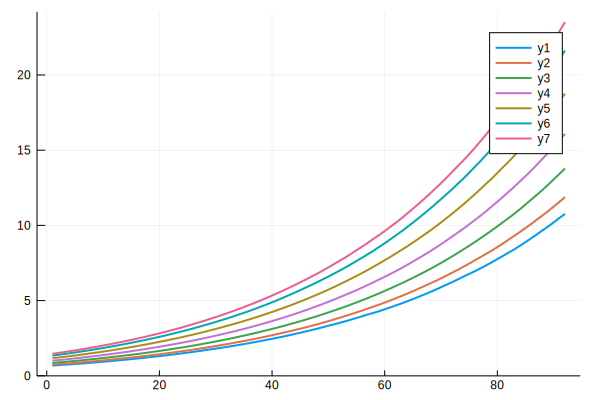

In [46]:
plot(standarded_wage[1:92,1],linewidth = 2)
plot!(standarded_wage[1:92,2],linewidth = 2)
plot!(standarded_wage[1:92,3],linewidth = 2)
plot!(standarded_wage[1:92,4],linewidth = 2)
plot!(standarded_wage[1:92,5],linewidth = 2)
plot!(standarded_wage[1:92,6],linewidth = 2)
plot!(standarded_wage[1:92,7],linewidth = 2)

In [36]:
maximum(h_sim_m_nonc)

524.9129163262224

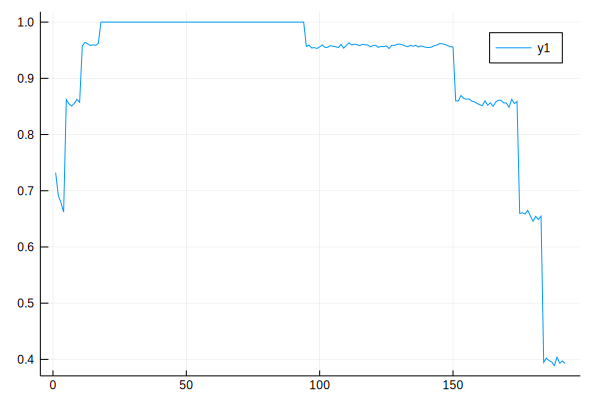

In [47]:
employment_rate = []
for i = 1:P_nonc.J
    push!(employment_rate,mean(labor_sim_m_nonc[i,:])) #the employment_rate for the ith line
end

plot(employment_rate)